In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from sklearn.preprocessing import MinMaxScaler

# define plotting + statistical functions

In [2]:
def hierarchical_clustering(data, label, linkage, ax):
    import scipy.cluster.hierarchy as shc

    dend = shc.dendrogram(shc.linkage(data, method=linkage), 
                      ax= ax, labels=label,
                      leaf_font_size=8, leaf_rotation=90)
    
    from sklearn.cluster import AgglomerativeClustering
    cluster = AgglomerativeClustering(n_clusters=7, 
                                      affinity = 'euclidean', linkage = linkage)
    cluster_labels = cluster.fit_predict(data)
    
    return dend, cluster_labels

In [3]:
def do_pearson(x, y):
    from scipy.stats import pearsonr
    corr, p_val = pearsonr(x, y)
    return corr, p_val

In [4]:
def capping(input_df):
    # cap values above 1 and below 0 to 20% above/below
    df_capped = input_df.copy()

    for i in range(len(input_df.columns)-1):
        i+=1
        for j in range(len(input_df)):
            if input_df.iloc[j, i] > 1.2:
                df_capped.iloc[j, i] = 1.2
            elif input_df.iloc[j, i] < -0.2:
                df_capped.iloc[j, i ] = -0.2
    return df_capped

In [5]:
def plot_heatmap(data, columns, labels, cmap):
    fig, ax = plt.subplots(figsize=(10,15), dpi=100)

    im = ax.imshow(data, cmap=cmap, aspect='equal')

    # show all ticks...
    ax.set_xticks(np.arange(len(columns)))
    ax.set_yticks(np.arange(len(data)))
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # label ticks
    ax.set_xticklabels(columns, fontsize=8, rotation=70, 
                       rotation_mode='anchor', ha='left', va='center')
    ax.set_yticklabels(labels, fontsize=8)

    # set colorbar
    cbar = fig.colorbar(im, cax = fig.add_axes([0.6, 0.5, 0.01, 0.1]), 
                    ax=ax, orientation='vertical', fraction=.1)
    cbar.ax.tick_params(labelsize=6)
    
    # hatch the background axes patch
    #ax.patch.set(hatch='xxx', edgecolor='black')
    ax.patch.set(color = 'grey', facecolor = 'grey')
    
    return fig

In [6]:
def scatter_plotting(labels, label_xval, label_yval, data, x_name, y_name):
    colors = {0:'cornflowerblue', 1:'darkblue', 2:'darkorange',
          3:'gold', 4:'lightsteelblue', 5:'blue',
          6:'blueviolet', 7:'cyan', 8:'black'}
    
    fig = plt.figure(figsize=(10,10), dpi=100)
    ax = fig.add_subplot(111)
    
    for i in range(len(labels)): # plot each point + it's index as text above
        ax.text(label_xval[i], label_yval[i], 
                labels[i], size=8, color='k')

    for j in data['cluster_labels'].unique():
        df_subset = data[data['cluster_labels']==j]
        ax.scatter(df_subset[x_name], df_subset[y_name], 
                   alpha=0.6, s=80, c=colors[j])

    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)

    return fig, ax

In [7]:
def correlate(df_to_plot, x_name, y_name):

    # plot scatter
    fig, ax = scatter_plotting(df_to_plot['variant'], df_to_plot[x_name], df_to_plot[y_name], df_to_plot, x_name, y_name)
    
    return fig, ax

In [8]:
def save_fig(fig, title=''):
    # output figure
    mpl.rcParams['pdf.fonttype'] = 42
    plt.savefig(f'{title}.pdf', transparent=True)
    return fig

# read in datasets

In [9]:
df_wing = pd.read_csv('fly_wing_size.csv', index_col=False)
df_eclosion = pd.read_csv('fly_eclosion.csv', index_col=False)
df_yeast = pd.read_csv('PTEN_Mighell_2018.csv', index_col=False)
df_vac14_hek = pd.read_csv('PTEN_VAC14_HEK.csv', index_col=False)
df_mcf10a = pd.read_csv('PTEN_MCF10A.csv', index_col=False)

## inspect datasets and make adjustments

In [ ]:
''' update 4/23/20: Payel requested to drop variants: 
eclosion - E256K, F56C, G132D, I135V, M198I, N340D, N340H, N356H, Q396R, R130X
wing size - N340H, N340D, C136M fxS44'''

'''update 4/9/20: now wing size data is normalized such that
0 is loss of function, 1 is functional'''

### inspect wing size data

In [10]:
df_wing.head()

,variant,wing_size
0,control,0.000000
1,WT,1.000000
2,PTEN- 4Ala,3.463187
3,C124S,-0.465176
4,D22E,-0.902782


In [11]:
# drop 4A so it doesn't skew data
df_wing.drop(2, axis=0, inplace=True)
print(df_wing.head())

   variant  wing_size
0  control   0.000000
1       WT   1.000000
3    C124S  -0.465176
4     D22E  -0.902782
5     P38H  -0.208456


### inspect eclosion time data

In [12]:
df_eclosion.head()

,variant,time,time.adj,sd.time,sd.time.adj,N.time,N.time.adj,sem.time,sem.time.adj,pvalue.from.WT,pvalue.from.NULL,Coefficients,time.scaled.means,time.scaled.sd,time.scaled.sem,time.adj.scaled.means,time.adj.scaled.sd,time.adj.scaled.sem
0,A121E,12.571429,9.988761,13.501839,12.668890,42,42,2.083379,1.954852,1.090000e-31,0.080943,-35.493288,-0.193717,0.495525,0.076461,-0.175509,0.419584,0.064743
1,A121P,28.800000,33.989297,13.454686,12.576896,15,15,3.473985,3.247341,1.401229e-02,0.000068,-11.492753,0.401880,0.493794,0.127497,0.619369,0.416537,0.107549
2,A126D,12.000000,16.559678,12.000000,11.514632,23,23,2.502173,2.400967,1.190000e-14,0.735246,-28.922372,-0.214689,0.440407,0.091831,0.042114,0.381355,0.079518
3,A126P,10.333333,10.750926,11.166276,9.713230,36,36,1.861046,1.618872,1.060000e-22,0.200159,-34.731124,-0.275857,0.409808,0.068301,-0.150267,0.321694,0.053616
4,A151P,20.526316,22.873467,7.332773,5.712228,38,38,1.189533,0.926646,3.100000e-12,0.019801,-22.608583,0.098231,0.269117,0.043657,0.251222,0.189184,0.030690


In [13]:
df_eclosion.rename(columns={'time':'eclosion_time'}, inplace=True)
df_eclosion.head()

,variant,eclosion_time,time.adj,sd.time,sd.time.adj,N.time,N.time.adj,sem.time,sem.time.adj,pvalue.from.WT,pvalue.from.NULL,Coefficients,time.scaled.means,time.scaled.sd,time.scaled.sem,time.adj.scaled.means,time.adj.scaled.sd,time.adj.scaled.sem
0,A121E,12.571429,9.988761,13.501839,12.668890,42,42,2.083379,1.954852,1.090000e-31,0.080943,-35.493288,-0.193717,0.495525,0.076461,-0.175509,0.419584,0.064743
1,A121P,28.800000,33.989297,13.454686,12.576896,15,15,3.473985,3.247341,1.401229e-02,0.000068,-11.492753,0.401880,0.493794,0.127497,0.619369,0.416537,0.107549
2,A126D,12.000000,16.559678,12.000000,11.514632,23,23,2.502173,2.400967,1.190000e-14,0.735246,-28.922372,-0.214689,0.440407,0.091831,0.042114,0.381355,0.079518
3,A126P,10.333333,10.750926,11.166276,9.713230,36,36,1.861046,1.618872,1.060000e-22,0.200159,-34.731124,-0.275857,0.409808,0.068301,-0.150267,0.321694,0.053616
4,A151P,20.526316,22.873467,7.332773,5.712228,38,38,1.189533,0.926646,3.100000e-12,0.019801,-22.608583,0.098231,0.269117,0.043657,0.251222,0.189184,0.030690


### inspect Mighell (yeast) data

In [14]:
df_yeast.head()

,Variant (one letter),Variant (three letter),Change,Wt_codon,Mut_codon,Type,Cum_score,Cum_SE,High_conf,High_conf_nature,...,B2_SE,B2_score,A3_SE,A3_score,B3_SE,B3_score,A_score,A_SE,B_score,B_SE
0,M1A,Met1Ala,A (Ala),ATG,GCT,missense,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M1V,Met1Val,V (Val),ATG,GTT,missense,NaN,NaN,NaN,NaN,...,0.894459,-0.151521,NaN,NaN,0.444826,0.661712,NaN,NaN,NaN,NaN
2,M1I,Met1Ile,I (Ile),ATG,ATT,missense,-0.679813,0.929740,False,Fail Both,...,NaN,NaN,0.362379,0.377438,NaN,NaN,-0.679813,0.92974,NaN,NaN
3,M1L,Met1Leu,L (Leu),ATG,TTG,missense,-1.545614,0.883483,False,Fail Both,...,0.692861,-0.151521,NaN,NaN,0.864111,-2.184489,NaN,NaN,-1.545614,0.883483
4,M1M,Met1Met,M (Met),ATG,ATG,WT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# rename col name for indexing the merge letter
df_yeast.rename(columns={'Variant (one letter)':'variant','Cum_score':'Mighell_score'}, 
                inplace=True)

In [16]:
# keep only two needed columns
df_yeast = df_yeast[df_yeast.columns[[0, 6]]]

# since Mighell's data is already normalized
# I'll put in WT as 0, KO as -4
df_yeast.loc[0, :] = ['WT', 0]
df_yeast.loc[1, :] = ['control', -4]

In [17]:
df_yeast.head()

,variant,Mighell_score
0,WT,0.000000
1,control,-4.000000
2,M1I,-0.679813
3,M1L,-1.545614
4,M1M,NaN


## inspect HEK, VAC14, MCF10A dsets

In [18]:
print(df_vac14_hek.head(), '\n')
print(df_mcf10a.head())

    variant     VAC14       HEK
0   no_PTEN  0.000000  0.000000
1        WT  1.000000  1.000000
2      P38H -0.257287 -0.378378
3     R130L -0.255608 -0.189189
4  C124S-4A -0.227811 -0.568047 

   variant  MCF10A
0  no_PTEN  0.0000
1       WT  1.0000
2      K6E  0.6689
3      K6I  0.5456
4     R15S  0.6130


### merge datasets

In [19]:
# start merging different datasets
df_merged = df_wing.merge(df_eclosion[['variant', 'eclosion_time']], on='variant', how='left') # merge wing+eclosion
df_merged = df_merged.merge(df_yeast, on='variant', how='left') # merge wing/eclosion+yeast

# rename control to no_PTEN
df_merged['variant'].replace({'control':'no_PTEN'}, inplace=True)

df_merged.head()

,variant,wing_size,eclosion_time,Mighell_score
0,no_PTEN,0.000000,17.849750,-4.000000
1,WT,1.000000,45.097297,0.000000
2,C124S,-0.465176,14.146552,-4.895643
3,D22E,-0.902782,16.888889,-1.454357
4,P38H,-0.208456,15.287671,-4.783403


### normalize + cap eclosion and Mighell for plotting heatmap

In [20]:
# normalized eclosion and Mighell
df_normed = df_merged.copy()

for i in range(2):
    i+=2
    for j in range(len(df_merged)):
        df_normed.iloc[j, i] = \
        ((df_merged.iloc[j, i]-df_merged.iloc[0, i])/ (df_merged.iloc[1, i]-df_merged.iloc[0, i]))

df_normed.head()

,variant,wing_size,eclosion_time,Mighell_score
0,no_PTEN,0.000000,0.000000,0.000000
1,WT,1.000000,1.000000,1.000000
2,C124S,-0.465176,-0.135909,-0.223911
3,D22E,-0.902782,-0.035264,0.636411
4,P38H,-0.208456,-0.094030,-0.195851


In [21]:
#merge in VAC14, HEK and MCF10A dsets

df_all = df_normed.copy()

for i in [df_vac14_hek, df_mcf10a]:
    df_all = df_all.merge(i, how='left', on='variant')

df_all.head()

,variant,wing_size,eclosion_time,Mighell_score,VAC14,HEK,MCF10A
0,no_PTEN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
1,WT,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000
2,C124S,-0.465176,-0.135909,-0.223911,0.039036,-0.586862,0.1203
3,D22E,-0.902782,-0.035264,0.636411,0.203508,-0.088757,NaN
4,P38H,-0.208456,-0.094030,-0.195851,-0.257287,-0.378378,0.6479


In [22]:
# cap values above 1 and below 0 to 20% above/below for plotting heatmap
df_capped = capping(df_all)
df_capped

,variant,wing_size,eclosion_time,Mighell_score,VAC14,HEK,MCF10A
0,no_PTEN,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0000
1,WT,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.0000
2,C124S,-0.200000,-0.135909,-0.200000,0.039036,-2.000000e-01,0.1203
3,D22E,-0.200000,-0.035264,0.636411,0.203508,-8.875740e-02,NaN
4,P38H,-0.200000,-0.094030,-0.195851,-0.200000,-2.000000e-01,0.6479
...,...,...,...,...,...,...,...
93,P354Q,0.759744,1.171776,1.022765,1.061492,1.200000e+00,0.8232
94,I400V,0.754183,0.428982,NaN,1.006796,1.011905e+00,NaN
95,K402N,0.126912,0.776226,0.683824,0.723201,1.023669e+00,NaN
96,G44D,0.390293,-0.200000,0.229917,0.163274,1.730000e-18,0.3768


# analyze all data

## heatmap for all data

In [30]:
# grab AA positions
AA_position = []
for i in df_all['variant']:
    try:
        AA_position.append(int(i[1:-1]))
    except ValueError:
        AA_position.append(0)

df_all['AA_position'] = AA_position

# sort by aa position
df_all = df_all.sort_values(by=['AA_position'], axis=0).reset_index(drop=True)

In [31]:
# capping values above/blow 1/0 to 1.2/-0.2
df_all_capped = capping(df_all)
df_all_capped

,variant,wing_size,eclosion_time,Mighell_score,VAC14,HEK,MCF10A,AA_position
0,no_PTEN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0
1,WT,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,0.0
2,I135fs,0.109975,-0.096580,NaN,NaN,NaN,NaN,0.0
3,C124S-4A,-0.139094,-0.125417,NaN,-0.200000,-0.200000,NaN,0.0
4,M1I,-0.057725,-0.106281,0.830047,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...
93,P354Q,0.759744,1.171776,1.022765,1.061492,1.200000,0.8232,1.2
94,P357S,0.834664,0.686143,0.590567,1.008465,1.059172,NaN,1.2
95,T363N,0.998301,0.338380,0.858815,1.059160,0.905325,NaN,1.2
96,I400V,0.754183,0.428982,NaN,1.006796,1.011905,NaN,1.2


In [164]:
#all_data_scaled = MinMaxScaler().fit_transform(df_all.iloc[:, 1:-1])

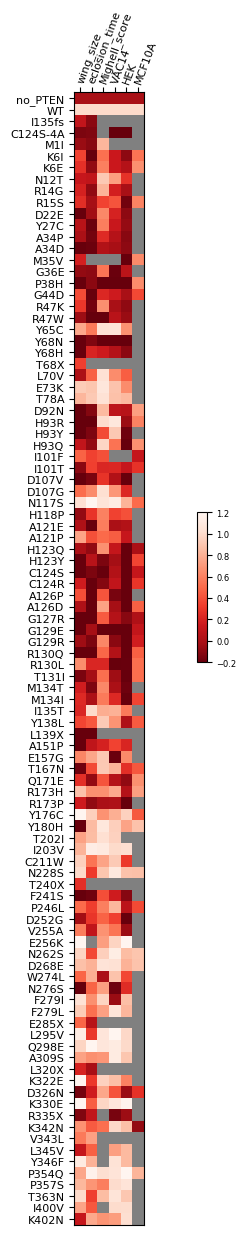

In [262]:
heatmap_data = df_all_capped.iloc[:, 1:-1]
labels = df_all_capped['variant'].tolist()

#heatmap_data = all_data_scaled
#labels = df_all['variant'].tolist()


fig = plot_heatmap(heatmap_data, df_all_capped.columns[1:-1], labels, 'Reds_r')

# save fig
mpl.rcParams['ps.fonttype'] = 42
fig.savefig('data_comparison_heatmap_by_aa.pdf', transparent=True)

plt.show()

## clustering all data

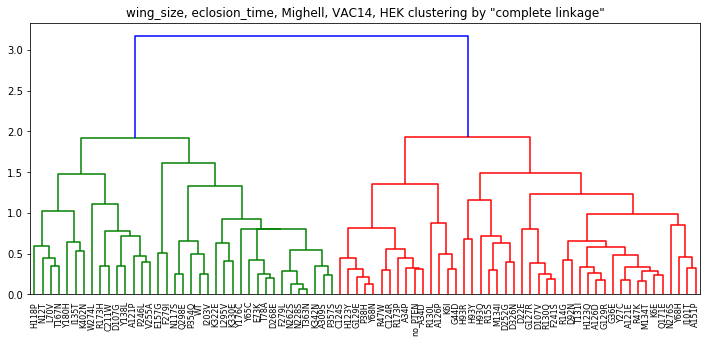

In [82]:
linkage = 'complete'

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
# hierarchical_clustering(data, label, linkage, ax)
dend, cluster_labels = hierarchical_clustering(
                                data = df_all.iloc[:, 1:-2].dropna().reset_index(drop=True), 
                                label = df_all.iloc[:, :-2].dropna()['variant'].to_list(), 
                                linkage = linkage,
                                ax = ax)

ax.set_title(f'wing_size, eclosion_time, Mighell, VAC14, HEK clustering by "{linkage} linkage"')

# output figure
mpl.rcParams['pdf.fonttype'] = 42
plt.savefig(f'all_data_dendrogram ({linkage}).pdf', transparent=True)

plt.show()

In [79]:
# re-index data according to cluster labels
data_clustered = df_all_capped.iloc[:, :-2].dropna().reset_index(drop=True).reindex(dend['leaves'])
data_clustered.head()

,variant,wing_size,eclosion_time,Mighell_score,VAC14,HEK
30,H118P,-0.070744,0.293472,0.601692,0.350474,0.404762
4,N12T,0.130851,0.104226,0.919713,0.726773,0.284024
19,L70V,0.014905,0.470813,1.039242,0.648596,0.461342
51,T167N,-0.171130,0.380455,0.917410,0.821710,0.270270
56,Y180H,-0.200000,0.852450,1.084011,0.943517,0.750391


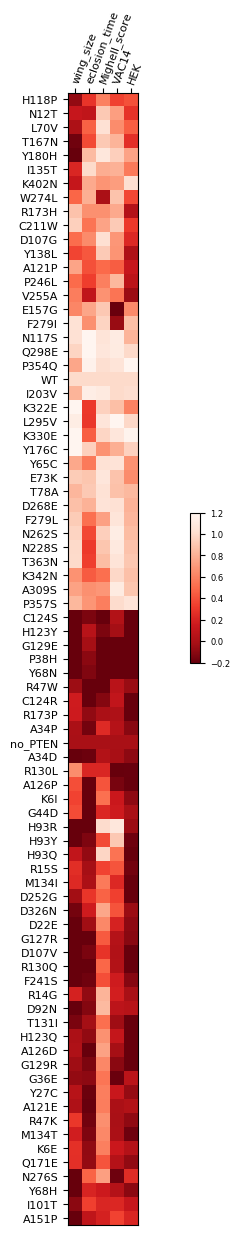

In [81]:
# plot heatmap in order of cluster labels
# plot_heatmap(data, columns, labels, cmap)
fig = plot_heatmap(data_clustered.iloc[:,1:], data_clustered.columns[1:], data_clustered['variant'], 'Reds_r')

# save fig
mpl.rcParams['ps.fonttype'] = 42
plt.savefig(f'all_data_heatmap_clustered ({linkage}).pdf', transparent=True)

plt.show()

## 3-way comparisons (wing vs HEK vs Mighell)

In [23]:
df_all.head()

,variant,wing_size,eclosion_time,Mighell_score,VAC14,HEK,MCF10A
0,no_PTEN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
1,WT,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000
2,C124S,-0.465176,-0.135909,-0.223911,0.039036,-0.586862,0.1203
3,D22E,-0.902782,-0.035264,0.636411,0.203508,-0.088757,NaN
4,P38H,-0.208456,-0.094030,-0.195851,-0.257287,-0.378378,0.6479


In [24]:
clustering_data = df_all.drop(columns=['eclosion_time','VAC14','MCF10A']).dropna().reset_index(drop=True)
clustering_data

,variant,wing_size,Mighell_score,HEK
0,no_PTEN,0.000000,0.000000,0.000000e+00
1,WT,1.000000,1.000000,1.000000e+00
2,C124S,-0.465176,-0.223911,-5.868615e-01
3,D22E,-0.902782,0.636411,-8.875740e-02
4,P38H,-0.208456,-0.195851,-3.783784e-01
...,...,...,...,...
77,K342N,0.679118,0.522926,8.757396e-01
78,P354Q,0.759744,1.022765,1.391753e+00
79,K402N,0.126912,0.683824,1.023669e+00
80,G44D,0.390293,0.229917,1.730000e-18


In [25]:
cols = ['variant', 'wing_size', 'HEK', 'Mighell_score']
clustering_data = clustering_data[cols]
clustering_data.head()

,variant,wing_size,HEK,Mighell_score
0,no_PTEN,0.000000,0.000000,0.000000
1,WT,1.000000,1.000000,1.000000
2,C124S,-0.465176,-0.586862,-0.223911
3,D22E,-0.902782,-0.088757,0.636411
4,P38H,-0.208456,-0.378378,-0.195851


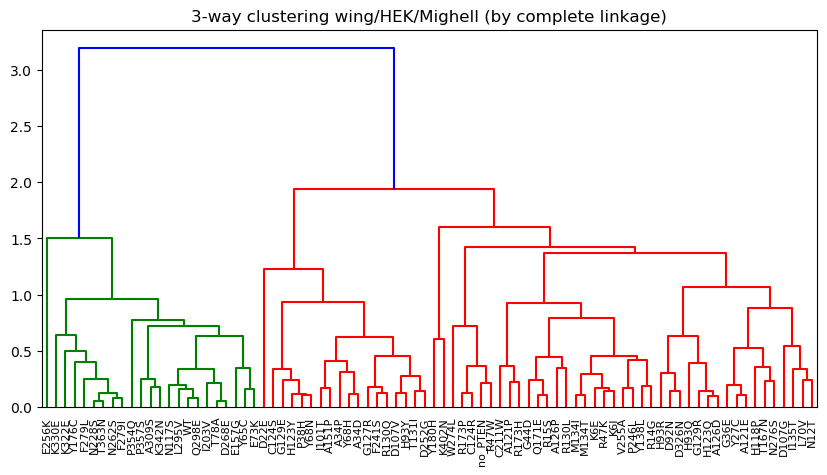

In [26]:
linkage_method = 'complete'

fig = plt.figure(figsize=(10,5), dpi=100)
ax = fig.add_subplot(111)
dend, cluster_labels = hierarchical_clustering(
                              clustering_data.iloc[:, 1:], 
                              clustering_data['variant'].tolist(),
                              linkage_method, ax)

ax.set_title(f"3-way clustering wing/HEK/Mighell (by {linkage_method} linkage)")

#save_fig(fig, title=f'WHM_dendrogram ({linkage_method})')

plt.show()

In [27]:
# re-index data according to cluster labels
heatmap_data = df_capped[['variant', 'wing_size', 'Mighell_score', 'HEK']].dropna().reset_index(drop=True).reindex(dend['leaves'])
heatmap_data.head()

,variant,wing_size,Mighell_score,HEK
70,E256K,1.200000,0.728004,1.200000
73,K330E,1.200000,0.976313,1.178571
39,K322E,1.200000,0.958300,0.607143
20,Y176C,1.200000,0.677128,0.958580
36,F279L,0.931094,0.740493,0.833333


In [28]:
heatmap_data = heatmap_data[cols]

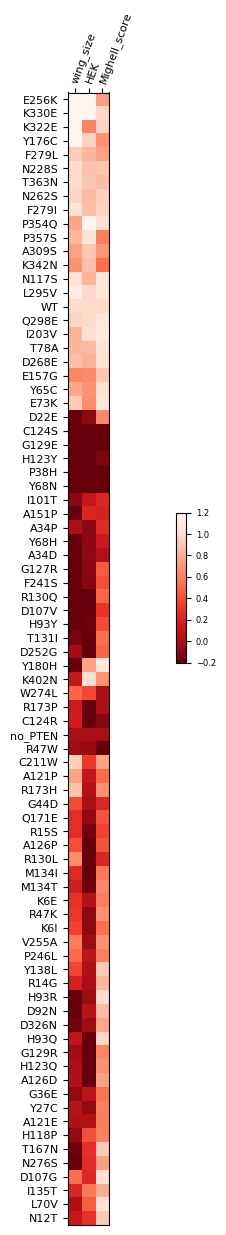

In [38]:
# plot heatmap in order of cluster labels
# plot_heatmap(data, columns, labels, cmap)
fig = plot_heatmap(heatmap_data.iloc[:,1:], heatmap_data.columns[1:], heatmap_data['variant'], 'Reds_r')

save_fig(fig, title=f'WHM_heatmap_clustered ({linkage_method})')

plt.show()

## plot correlation (scatter) plots using cluster assignments

In [29]:
# prep the data for scatter plotting
d = {'variant':clustering_data['variant'], 'cluster_labels':cluster_labels}
df_labels = pd.DataFrame(d)
print(df_labels)

    variant  cluster_labels
0   no_PTEN               5
1        WT               1
2     C124S               0
3      D22E               0
4      P38H               0
..      ...             ...
77    K342N               1
78    P354Q               1
79    K402N               3
80     G44D               6
81    P246L               6

[82 rows x 2 columns]


In [30]:
np.unique(cluster_labels)

array([0, 1, 2, 3, 4, 5, 6])

In [31]:
df_to_plot = df_all.merge(df_labels, on='variant', how='left')
display(df_to_plot)

,variant,wing_size,eclosion_time,Mighell_score,VAC14,HEK,MCF10A,cluster_labels
0,no_PTEN,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0000,5.0
1,WT,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.0000,1.0
2,C124S,-0.465176,-0.135909,-0.223911,0.039036,-5.868615e-01,0.1203,0.0
3,D22E,-0.902782,-0.035264,0.636411,0.203508,-8.875740e-02,NaN,0.0
4,P38H,-0.208456,-0.094030,-0.195851,-0.257287,-3.783784e-01,0.6479,0.0
...,...,...,...,...,...,...,...,...
93,P354Q,0.759744,1.171776,1.022765,1.061492,1.391753e+00,0.8232,1.0
94,I400V,0.754183,0.428982,NaN,1.006796,1.011905e+00,NaN,NaN
95,K402N,0.126912,0.776226,0.683824,0.723201,1.023669e+00,NaN,3.0
96,G44D,0.390293,-0.401015,0.229917,0.163274,1.730000e-18,0.3768,6.0


In [56]:
df_to_plot[df_to_plot['variant']=='I203V']

,variant,wing_size,eclosion_time,Mighell_score,VAC14,HEK,MCF10A,cluster_labels
38,I203V,0.821931,1.137988,1.112498,0.997972,1.015697,NaN,1.0


In [32]:
# fill na with 8 to plot them gray later in the scatterplot
filler = {'cluster_labels':8}
df_to_plot.fillna(value=filler, inplace=True)

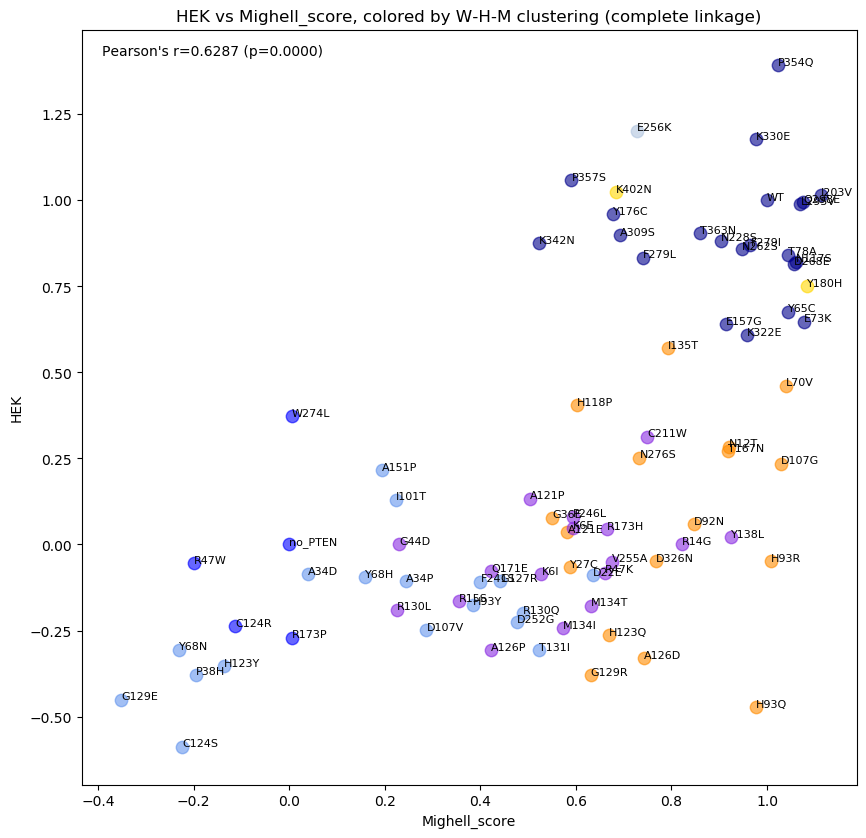

In [33]:
x = 'Mighell_score'
y = 'HEK'
df_temp = df_to_plot[['variant', x, y, 'cluster_labels']].dropna().reset_index(drop=True)

# calculate overall Pearson's r
corr, p = do_pearson(df_temp[x], df_temp[y])
pear_r = f"Pearson's r={corr:.4f} (p={p:.4f})"

# plot scatterplot
fig, ax = correlate(df_temp, x, y)
text_x = ax.get_xlim()[0]*0.9
text_y = ax.get_ylim()[1]*0.95
ax.text(text_x, text_y, pear_r)
title = f'{y} vs {x}, colored by W-H-M clustering ({linkage_method} linkage)'
ax.set_title(title)

save_fig(fig, title=f"{y}-{x} (WHM clustering)")

plt.show()